# Face Validation Methods

Using the pre-trained Keras FaceNet model provided by Hiroki Taniai. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import random 
random.seed(42)
import os
import cv2
from sklearn.metrics import classification_report, f1_score, make_scorer
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import tensorflow
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
import tensorflow.keras.backend as K

## Data Preprocessing

The facenet model requires images 160x160x3, will be resizing our images and converting to greyscale Using Siamese network requires the data to be processed for binary classification:every sample contains two images with corresponding binary target. Where matched(with target of 1) and unmatched(with target of 0) pairs will be created.

In [2]:
# Creating labels

labels=[]  #contains target labels
images =[]  #contains images

for dirname, _, filenames in os.walk('/kaggle/input/yale-face-database/data'):    
    
    for filename in filenames:
        if filename!="Readme.txt":
            img=plt.imread(os.path.join(dirname, filename))
       
            img= cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) 
            img=cv2.resize(img, (160,160),interpolation = cv2.INTER_AREA)
            labels.append(int(filename[7:9]))
            images.append(img)

In [3]:
# viewing how many images belong to each subject
for i in range(1,16):
    person=[]
    for u in range(len(labels)):
        if labels[u]==i:
            person.append(images[u])
    print(str(len(person))+" images  for subject "+ str(i))

11 images  for subject 1
11 images  for subject 2
11 images  for subject 3
11 images  for subject 4
11 images  for subject 5
11 images  for subject 6
11 images  for subject 7
11 images  for subject 8
11 images  for subject 9
11 images  for subject 10
11 images  for subject 11
11 images  for subject 12
11 images  for subject 13
11 images  for subject 14
11 images  for subject 15


In [4]:
# Generate index for each label
unique_labels = np.unique(labels)

label_wise_indices = dict()
for label in unique_labels:
    label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

In [5]:
# Generate image pairs and labels
pair_images = []
pair_labels = []
newX_1 = []
newX_2 = []

In [6]:
for index, image in enumerate(images):
    pos_indices = label_wise_indices.get(labels[index])
    pos_image = images[np.random.choice(pos_indices)]
    pair_images.append((image, pos_image))
    
    newX_1.append(image)
    newX_2.append(pos_image)
    
    pair_labels.append(0)

    neg_indices = list(range(1,index)) + list(range(index+1,11))
    neg_image = images[np.random.choice(neg_indices)]
    pair_images.append((image, neg_image))
    
    
    newX_1.append(image)
    newX_2.append(neg_image)
    
    pair_labels.append(1)


images_dataset = np.array(pair_images)
labels_dataset = np.array(pair_labels)

In [7]:
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

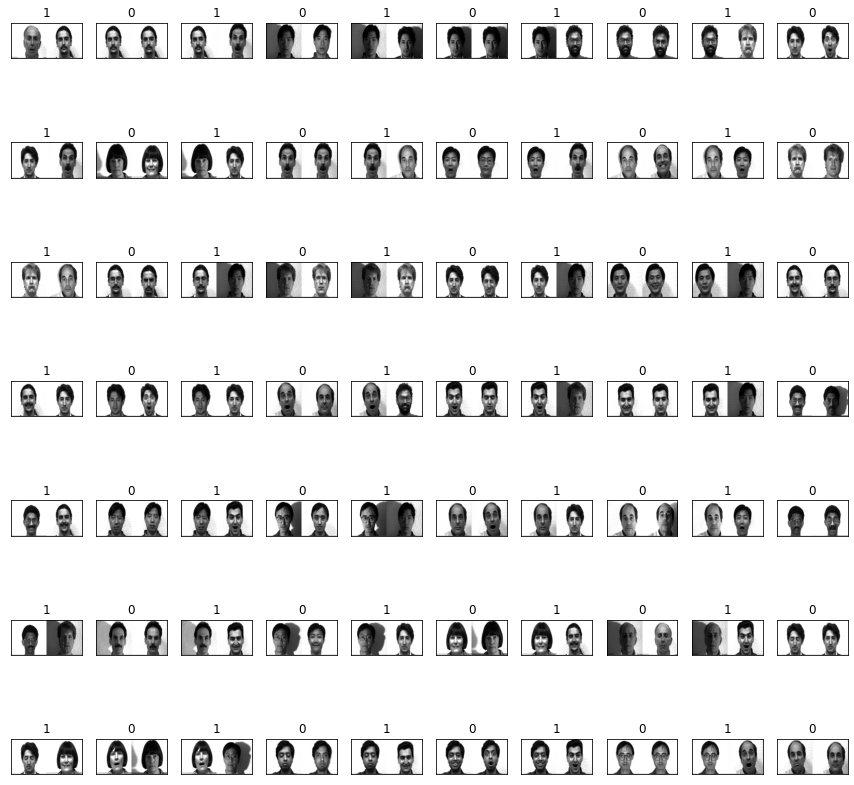

In [8]:
fig=plt.figure(figsize=(15, 15))
columns = 10
rows = 7
for i in range(1, columns*rows +1):
    ax=fig.add_subplot(rows, columns, i)
    
    plt.imshow(np.concatenate([newX_1[i],newX_2[i]], axis=1))
    ax.title.set_text(pair_labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Training 

In [9]:
# initializing the facenet model

base_model = models.load_model('../input/facenet-model/facenet_keras.h5')
base_model.load_weights("../input/facenet-model/facenet_keras_weights.h5")
base_model.trainable=False

2022-08-16 09:46:51.689035: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
# a function to calculate the distance between the pair images
def distance(vecs):
    x, y = vecs
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    
    return K.abs(x-y)

In [11]:
embedding=Model(base_model.inputs, base_model.outputs)


anchor_input=Input((160,160,3))
compare_input=Input((160,160,3))

featuresA=embedding(anchor_input)
featuresB=embedding(compare_input)

distances= Lambda(distance)([featuresA,featuresB])



x= Dense(96, activation="relu")(distances)
x= Dropout(0.3)(x)
x= Dense(64)(x)
outputs = Dense(1, activation="sigmoid")(x)
outputs = Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

In [12]:
siamese_model.compile(loss="binary_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.01), metrics=["accuracy"])
siamese_model.summary()

history = siamese_model.fit([images_dataset[:, 0, :]/255, images_dataset[:, 1, :]/255], labels_dataset,
                            epochs=20, validation_split = 0.2, batch_size = 16)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          22808144    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           model[0][0]                

2022-08-16 09:47:00.206472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
17/17 [==============================] - 38s 1s/step - loss: 0.6758 - accuracy: 0.5114 - val_loss: 0.6562 - val_accuracy: 0.5606
Epoch 2/20
17/17 [==============================] - 18s 1s/step - loss: 0.6410 - accuracy: 0.5417 - val_loss: 0.6331 - val_accuracy: 0.5606
Epoch 3/20
17/17 [==============================] - 19s 1s/step - loss: 0.6165 - accuracy: 0.5795 - val_loss: 0.6127 - val_accuracy: 0.5758
Epoch 4/20
17/17 [==============================] - 18s 1s/step - loss: 0.5952 - accuracy: 0.6402 - val_loss: 0.5938 - val_accuracy: 0.6364
Epoch 5/20
17/17 [==============================] - 19s 1s/step - loss: 0.5736 - accuracy: 0.6818 - val_loss: 0.5764 - val_accuracy: 0.6212
Epoch 6/20
17/17 [==============================] - 18s 1s/step - loss: 0.5552 - accuracy: 0.7008 - val_loss: 0.5607 - val_accuracy: 0.6667
Epoch 7/20
17/17 [==============================] - 18s 1s/step - loss: 0.5372 - accuracy: 0.7992 - val_loss: 0.5451 - val_accuracy: 0.7121
Epoch 8/20
17/17 [==

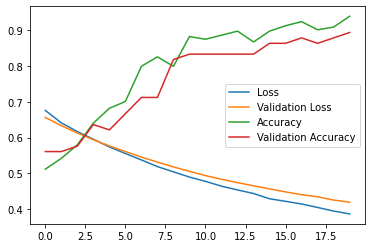

In [13]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])